## Import the Libraries

In [56]:
#import the required libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

# Define Paramter

In [57]:
# Generated image size
RESIZE_HEIGHT = 607

NUM_ITER = 6000

# Weights of the different loss components
CONTENT_WEIGHT = 8e-4 # 8e-4
STYLE_WEIGHT = 8e-1 # 8e-4

# The layer to use for the content loss.
CONTENT_LAYER_NAME = "block5_conv2" # "block2_conv2"

# List of layers to use for the style loss.
STYLE_LAYER_NAMES = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

In [58]:

def get_result_image_size(image_path, result_height):
    image_width, image_height = keras.preprocessing.image.load_img(image_path).size
    result_width = int(image_width * result_height / image_height)
    return result_height, result_width

def preprocess_image(image_path, target_height, target_width):
    img = keras.preprocessing.image.load_img(image_path, target_size = (target_height, target_width))
    arr = keras.preprocessing.image.img_to_array(img)
    arr = np.expand_dims(arr, axis = 0)
    arr = vgg19.preprocess_input(arr)
    return tf.convert_to_tensor(arr)

def get_model():
    # Build a VGG19 model loaded with pre-trained ImageNet weights
    model = vgg19.VGG19(weights = 'imagenet', include_top = False)

    # Get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    # Set up a model that returns the activation values for every layer in VGG19 (as a dict).
    return keras.Model(inputs = model.inputs, outputs = outputs_dict)

def get_optimizer():
    return keras.optimizers.Adam(
        keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 8.0, decay_steps = 445, decay_rate = 0.98
            # initial_learning_rate = 2.0, decay_steps = 376, decay_rate = 0.98
        )
    )

def compute_loss(feature_extractor, combination_image, content_features, style_features):
    combination_features = feature_extractor(combination_image)
    loss_content = compute_content_loss(content_features, combination_features)
    loss_style = compute_style_loss(style_features, combination_features, combination_image.shape[1] * combination_image.shape[2])

    return CONTENT_WEIGHT * loss_content + STYLE_WEIGHT * loss_style

# A loss function designed to maintain the 'content' of the original_image in the generated_image
def compute_content_loss(content_features, combination_features):
    original_image = content_features[CONTENT_LAYER_NAME]
    generated_image = combination_features[CONTENT_LAYER_NAME]

    return tf.reduce_sum(tf.square(generated_image - original_image)) / 2

def compute_style_loss(style_features, combination_features, combination_size):
    loss_style = 0

    for layer_name in STYLE_LAYER_NAMES:
        style_feature = style_features[layer_name][0]
        combination_feature = combination_features[layer_name][0]
        loss_style += style_loss(style_feature, combination_feature, combination_size) / len(STYLE_LAYER_NAMES)

    return loss_style


def style_loss(style_features, combination_features, combination_size):
    S = gram_matrix(style_features)
    C = gram_matrix(combination_features)
    channels = style_features.shape[2]
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (combination_size ** 2))

def gram_matrix(x):
   x = tf.transpose(x, (2, 0, 1))
   features = tf.reshape(x, (tf.shape(x)[0], -1))
   gram = tf.matmul(features, tf.transpose(features))
   return gram

def save_result(generated_image, result_height, result_width, name):
    img = deprocess_image(generated_image, result_height, result_width)
    keras.preprocessing.image.save_img(name, img)

# Util function to convert a tensor into a valid image
def deprocess_image(tensor, result_height, result_width):
    tensor = tensor.numpy()
    tensor = tensor.reshape((result_height, result_width, 3))

    # Remove zero-center by mean pixel
    tensor[:, :, 0] += 103.939
    tensor[:, :, 1] += 116.779
    tensor[:, :, 2] += 123.680

    # 'BGR'->'RGB'
    tensor = tensor[:, :, ::-1]
    return np.clip(tensor, 0, 255).astype("uint8")

## Original and Style images

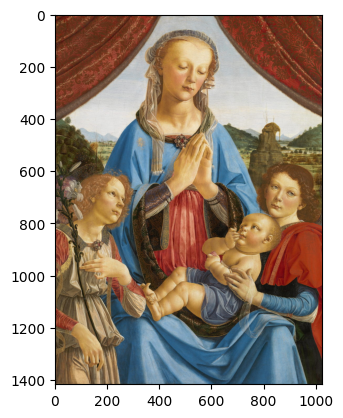

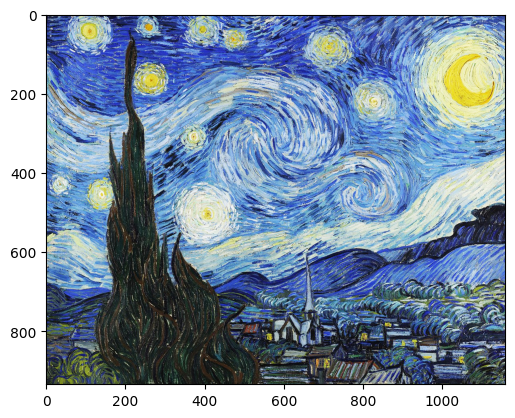

In [59]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
content_image_path = "/content/leonard.jpg"
style_image_path = "/content/starry_night.jpg"
cont_img = mpimg.imread(content_image_path)
plt.imshow(cont_img)
plt.show()
sty_img = mpimg.imread(style_image_path)
plt.imshow(sty_img)
plt.show()


## Preprocessing

In [60]:
result_height, result_width = get_result_image_size(content_image_path, RESIZE_HEIGHT)
print("result resolution: (%d, %d)" % (result_height, result_width))

result resolution: (607, 438)


In [61]:
# Preprocessing
content_tensor = preprocess_image(content_image_path, result_height, result_width)
style_tensor = preprocess_image(style_image_path, result_height, result_width)
generated_image = tf.Variable(tf.random.uniform(style_tensor.shape, dtype=tf.dtypes.float32))

## Building the model

In [62]:
# Build model
model = get_model()
optimizer = get_optimizer()
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [63]:
content_features = model(content_tensor)
style_features = model(style_tensor)

## Train the Model

In [64]:
# Optimize result image
for iter in range(5000):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, generated_image, content_features, style_features)

    grads = tape.gradient(loss, generated_image)

    print("iter: %4d, loss: %8.f" % (iter, loss))
    optimizer.apply_gradients([(grads, generated_image)])

iter:    0, loss: 16383660
iter:    1, loss: 15634962
iter:    2, loss: 13717585
iter:    3, loss: 10980808
iter:    4, loss:  8239414
iter:    5, loss:  6560772
iter:    6, loss:  5954680
iter:    7, loss:  5499658
iter:    8, loss:  4771169
iter:    9, loss:  4035532
iter:   10, loss:  3534662
iter:   11, loss:  3250002
iter:   12, loss:  3057543
iter:   13, loss:  2866975
iter:   14, loss:  2652806
iter:   15, loss:  2430372
iter:   16, loss:  2221776
iter:   17, loss:  2037734
iter:   18, loss:  1875810
iter:   19, loss:  1730302
iter:   20, loss:  1599310
iter:   21, loss:  1479928
iter:   22, loss:  1368876
iter:   23, loss:  1267194
iter:   24, loss:  1178472
iter:   25, loss:  1103611
iter:   26, loss:  1039860
iter:   27, loss:   984213
iter:   28, loss:   934870
iter:   29, loss:   890342
iter:   30, loss:   848512
iter:   31, loss:   808453
iter:   32, loss:   771474
iter:   33, loss:   737819
iter:   34, loss:   707437
iter:   35, loss:   680416
iter:   36, loss:   656435
i

In [65]:
#save the result image
name = "result.png"
save_result(generated_image, result_height, result_width, name)

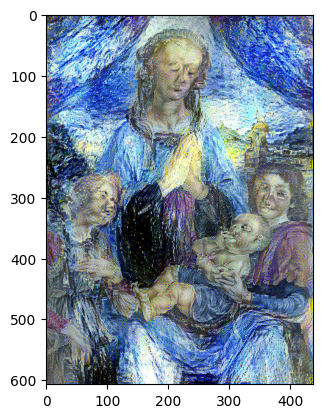

In [66]:
#show styled image
sty_img = mpimg.imread("result.png")
plt.imshow(sty_img)
plt.show()

## Metrics to evalute the generated image
We used MSE, structural_similarity, PSNR for getting integrity of images

In [54]:
original_image = mpimg.imread(content_image_path)
original_image = original_image.astype(np.float32)
sty_img = sty_img.astype(np.float32)

# Calculate the Mean Squared Error (MSE)
mse = np.mean((original_image - generated_image)**2)
print(" Mean Square Error: ")
print(mse)
# Calculate the PSNR
psnr = 10 * np.log10((255**2) / mse)

# Display the PSNR
print(f"PSNR: {psnr} dB")

23037.053
PSNR: 4.506534444097875 dB


In [55]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim


gray_original = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
gray_generated = cv2.cvtColor(sty_img, cv2.COLOR_BGR2GRAY)

# Calculate the Structural Similarity Index (SSI)
ssi_index, _ = ssim(gray_original, gray_generated, full=True)

print(f"SSI: {ssi_index}")

SSI: 2.0986622124428595e-05
